In [1]:
#necessary libraries
import librosa
import os
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#describe genres by label number
dict_characters={0: 'Hip-Hop',1: 'Pop',2: 'Folk',3: 'Rock',4: 'Experimental',5: 'International',6: 'Instrumental',7: 'Electronic'}

In [3]:
#load class_weights
class_weight=np.load('class_weight3D.npy')

In [4]:
#load the variables
x_train=np.load('x_train3D30.npy')
x_test=np.load('x_test3D30.npy')
y_trainHot=np.load('y_trainHot3D30.npy')
y_testHot=np.load('y_testHot3D30.npy')

In [5]:
# Helper Functions, Learning Curves, and Confusion Matrix
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pylab as plt

#save all previous epochs for use in plotting Keras Learning Curve
#this is used in function below called plotKerasLearningCurve
class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

#Keras Learning Curve function
def plotKerasLearningCurve(title='Learning Curves'):
    plt.figure(figsize=(10,5))
    metrics = np.load('logs3D2.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')
    plt.ylabel('Accuracy')
    plt.title(title)
    
#Confuson Matrix function
import itertools
def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

/home/cc/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [6]:
#deep learning libraries
from keras.models import Sequential
from keras.layers import Dense,Dropout,Activation,Flatten,Conv1D,MaxPool1D,BatchNormalization
from keras.optimizers import Adam
from keras import regularizers
import sklearn
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix

In [7]:
#scale the features
train_mean=np.mean(x_train, axis=0)
train_std=np.std(x_train, axis=0)

In [8]:
x_train=(x_train-train_mean)/train_std
x_test=(x_test-train_mean)/train_std

In [9]:
#****EDIT THIS FOR TRYING DIFFERENT MODELS****#

#deep learning model
#a = x_train
#b = y_trainHot
#c = x_test
#d = y_testHot
#e = number of epochs
def runCNNmodel(a,b,c,d):
    batch=32
    num_labels=8
    one, two = x_train.shape[1], x_train.shape[2]
    input_shape = (one, two)
    #intialize model
    model=Sequential()
    
    #visible layers
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu',input_shape=input_shape, kernel_regularizer=regularizers.l2(.1)))
    model.add(MaxPool1D(pool_size=2))
    model.add(BatchNormalization())
    model.add(Dropout(0.15))
    
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu',input_shape=input_shape, kernel_regularizer=regularizers.l2(.1)))
    model.add(MaxPool1D(pool_size=2))
    model.add(BatchNormalization())
    model.add(Dropout(0.15))
    
    #8 output nodes
    model.add(Flatten())
    #model.add(Dense(512, activation='relu')) #hidden layers
    #model.add(Dropout(0.15))
    model.add(Dense(num_labels, activation='softmax'))
    
    return model

In [10]:
#run the model
model=runCNNmodel(x_train,y_trainHot,x_test,y_testHot)

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 78, 32)            240032    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 39, 32)            0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 39, 32)            128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 39, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 37, 64)            6208      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 18, 64)            0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 18, 64)            256       
__________

Train on 5586 samples, validate on 2394 samples
Epoch 1/50
5586/5586 [==============================] - 24s 4ms/step - loss: 6.8286 - acc: 0.2954 - val_loss: 3.5544 - val_acc: 0.3304
Epoch 2/50
5586/5586 [==============================] - 23s 4ms/step - loss: 3.0163 - acc: 0.3690 - val_loss: 2.5759 - val_acc: 0.3801
Epoch 3/50
5586/5586 [==============================] - 23s 4ms/step - loss: 2.4098 - acc: 0.3972 - val_loss: 2.3113 - val_acc: 0.3906
Epoch 4/50
5586/5586 [==============================] - 24s 4ms/step - loss: 2.1809 - acc: 0.4146 - val_loss: 2.1828 - val_acc: 0.4085
Epoch 5/50
5586/5586 [==============================] - 27s 5ms/step - loss: 2.0926 - acc: 0.4329 - val_loss: 2.0872 - val_acc: 0.4169
Epoch 6/50
5586/5586 [==============================] - 29s 5ms/step - loss: 2.0145 - acc: 0.4375 - val_loss: 2.1213 - val_acc: 0.4194
Epoch 7/50
5586/5586 [==============================] - 29s 5ms/step - loss: 1.9841 - acc: 0.4533 - val_loss: 2.0394 - val_acc: 0.3977
Epoch 8

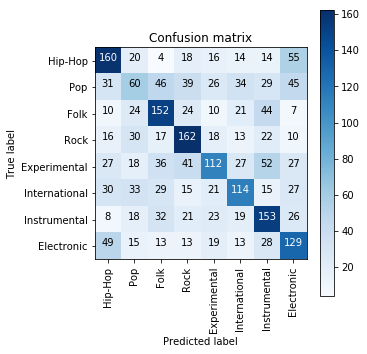

In [12]:
#compile the model
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

#train the model
history=model.fit(x_train,y_trainHot,batch_size=32,epochs=50,validation_data=(x_test,y_testHot),callbacks=[MetricsCheckpoint('logs3D2')], class_weight=class_weight)
    
#compute predictions for confusion matrix
Y_pred = model.predict(x_test)
print('\n', sklearn.metrics.classification_report(np.where(y_testHot > 0)[1], np.argmax(Y_pred, axis=1),target_names=list(dict_characters.values())), sep='')
Y_pred_classes = np.argmax(Y_pred,axis = 1)
Y_true = np.argmax(y_testHot,axis = 1)
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
    
#plot confusion matrix
plot_confusion_matrix(cm=confusion_mtx,classes=list(dict_characters.values()))

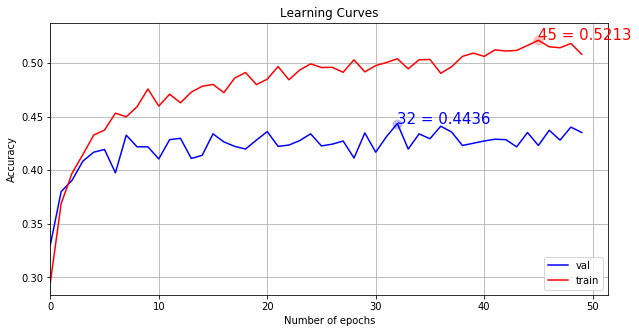

In [13]:
#plot learning curves across epochs
plotKerasLearningCurve()

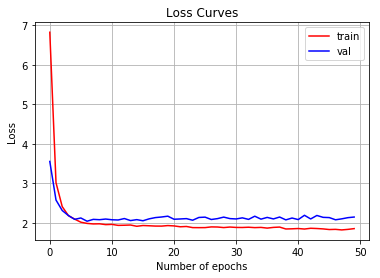

In [14]:
#plot the loss curves
plt.plot(history.history['loss'], color='red')
plt.plot(history.history['val_loss'], color='blue')
plt.title('Loss Curves')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend(['train','val'], loc='upper right')
plt.grid()
plt.show()